# subset training data
This notebook contains functions to generate subsets from multiple raster sources

In [1]:
from glob import glob
import numpy as np
import xarray as xr
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
import random
import matplotlib.pyplot as plt

In [2]:
aso_path = '../data/ASO/ASO_50m_SD_withS1overpass/utm10n/ASO_50M_SD_American_20230131_clean.tif'
tile_path = '../data/polygons/train_utm10n_25km.shp'

In [137]:
ds = open_all_data(aso_path, '..')
ds.attrs['_FillValue'] = None

In [6]:
tiles = gpd.read_file(tile_path)

In [37]:
tile = tiles.loc[tiles['id']== 600.0]

In [138]:
tile_ds = ds.rio.clip(tile.geometry.values, crs=ds.rio.crs, drop=True)

In [71]:
tile_pixel_count = np.invert(np.isnan(tile_ds.aso_sd.values)).sum()
print(tile_pixel_count)

82199


In [40]:
subset_goal = round(pixel_count/(128**2)*5)

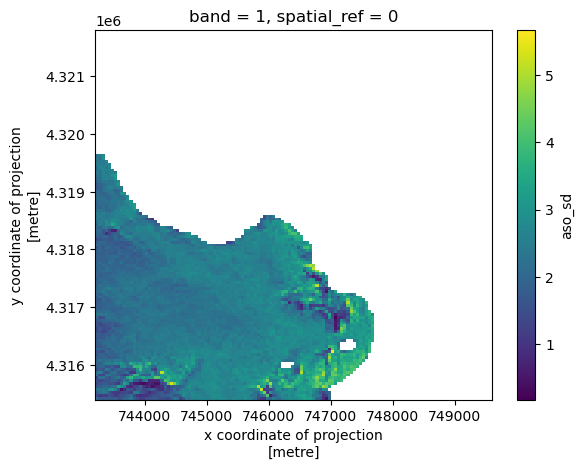

In [139]:
subset_ds = sample_ds(tile_ds, 128)
subset_ds.aso_sd.plot()

In [103]:
subset_ds['gap_map'] = np.multiply(np.isnan(subset_ds.aso_sd), 1)

In [134]:
def open_all_data(aso_path, home_path):
    aso_fn = aso_path.split('/')[-1][:-4]
    S1_snowon_path = glob(f'{home_path}/data/S1_rtc/S1_snow-on_*_for_{aso_fn}.nc')[0]
    S1_snowoff_path = glob(f'{home_path}/data/S1_rtc/S1_snow-off_*_for_{aso_fn}.nc')[0]
    S2_path = glob(f'{home_path}/data/S2/S2_*_for_{aso_fn}.nc')[0]
    fcf_path = glob(f'{home_path}/data/fcf/fcf_for_{aso_fn}.nc')[0]
    dem_path = glob(f'{home_path}/data/cop30/cop30_for_{aso_fn}.nc')[0]

    aso_da = rxr.open_rasterio(aso_path).squeeze()
    aso_da.attrs['_FillValue'] = None
    aso_da = aso_da.where(aso_da >= 0)
    aso_ds = aso_da.to_dataset(name='aso_sd')

    S1_snowon_ds = rxr.open_rasterio(S1_snowon_path).squeeze()
    S1_snowon_ds.attrs['_FillValue'] = None
    S1_snowon_ds = S1_snowon_ds.rename({'vv': 'snowon_vv', 'vh':'snowon_vh'})
    S1_snowon_ds['snowon_vv'] = S1_snowon_ds['snowon_vv'].where(S1_snowon_ds['snowon_vv'] >= 0)
    S1_snowon_ds['snowon_vh'] = S1_snowon_ds['snowon_vh'].where(S1_snowon_ds['snowon_vh'] >= 0)

    S1_snowoff_ds = rxr.open_rasterio(S1_snowoff_path).squeeze()
    S1_snowoff_ds.attrs['_FillValue'] = None
    S1_snowoff_ds = S1_snowoff_ds.rename({'vv': 'snowoff_vv', 'vh':'snowoff_vh'})
    S1_snowoff_ds['snowoff_vv'] = S1_snowoff_ds['snowoff_vv'].where(S1_snowoff_ds['snowoff_vv'] >= 0)
    S1_snowoff_ds['snowoff_vh'] = S1_snowoff_ds['snowoff_vh'].where(S1_snowoff_ds['snowoff_vh'] >= 0)
    
    S2_ds = rxr.open_rasterio(S2_path).squeeze()
    fcf_ds = rxr.open_rasterio(fcf_path).squeeze()
    fcf_ds = fcf_ds.rename({'__xarray_dataarray_variable__': 'fcf'})
    dem_ds = rxr.open_rasterio(dem_path).squeeze()
    dem_ds = dem_ds.rename({'__xarray_dataarray_variable__': 'elevation'})

    ds_list = [aso_ds, S1_snowon_ds, S1_snowoff_ds, S2_ds, fcf_ds, dem_ds]

    ds = xr.merge(ds_list, compat='override')

    return ds

In [13]:
def sample_ds(ds, subset_size):
    minx = 0
    miny = 0
    maxx = len(ds.x)-subset_size
    maxy = len(ds.y)-subset_size

    sub_minx = random.randint(minx, maxx)
    sub_miny = random.randint(miny, maxy)
    subset = ds.isel(x=slice(sub_minx, sub_minx+subset_size), y=slice(sub_miny, sub_miny+subset_size))
    
    return subset

In [ ]:
def subset_ASO(subset_size=128,
               avg_subs_per_pixel=5
              ):
    """
    Get random samples from multiple ASO rasters with different extents and timestamps
    """
    home_path = '..'
    utm_zones = ['utm10n', 'utm11n', 'utm12n', 'utm13n']

    # loop through utm zones
    for utm_zone in utm_zones:
        aso_paths = glob(f'{home_path}/data/ASO/ASO_50m_SD_withS1overpass/{utm_zone}/*')
        tile_names = [f'train_{utm_zone}_25km.shp', f'test_{utm_zone}_25km.shp', f'val_{utm_zone}_25km.shp']

        #loop through train, val, test tiles
        for tile_set in tile_names:
            # open tiles 
            tiles = gpd.read_file(f'{home_path}/data/polygons/{tile_set}')

            #loop through ASO rasters
            for aso_path in aso_paths:
                # open aso raster
                ds = open_all_data(aso_path, '..')

                # loop through tiles
                tiles = tiles.sample(frac=1)
                for i, tile in tiles.iterrows():
                    # clip to tile extent
                    try:
                        tile_ds = ds.rio.clip(tiles.iloc[i].geometry.values, crs=ds.rio.crs, drop=True)
                    except: #except if tile does not overlap interferogram
                        #print(f'no valid subsets in tile {i}')
                        continue
                    # set number of subsets to grab based on valid pixel count in tile 
                    tile_pixel_count = np.invert(np.isnan(tile_ds.aso_sd.values)).sum()
                    subset_goal = round(tile_pixel_count/(subset_size**2)*avg_subs_per_pixel)

                    subset_count = 0
                    while subset_count < subset_goal:
                        subset_ds = sample_ds(tile_ds, subset_size)
                        # check if subset has valid ASO pixels
                        if np.invert(np.isnan(subset_ds.aso_sd)).sum() == 0:
                            continue
                        else: # save subset
                            # create map of gaps
                            ds['gap_map'] = np.multiply(np.isnan(subset_ds.aso_sd), 1)
                            # fill nans and negatives with 0 
                            
                            
                            
                        
                        
                    


In [ ]:
# code from other project: 
def subset_noise(orbit_list, 
                 frame_list, 
                 year_list, 
                 subsets_desired, 
                 subset_type,
                 subset_size=128, 
                 max_time_s=1,
                 max_per_tile=3):
    '''
    subset hyp3 outputs using tiles
    '''
    
    home_path = '/mnt/d/indennt'
    # set number of subsets to 0
    subset_counter = 0
    granules_sampled = []
    tiles = gpd.read_file(f'{home_path}/polygons/{subset_type}_RGI_grid_25km.shp')
    
    #with open('granules_sampled.pkl', 'rb') as f:
        #granules_sampled = pickle.load(f)
    
    # continue to run until desired subset number is reached
    #while subset_counter < subsets_desired:
    for orbit in orbit_list:
        signal_path = f'{home_path}/signal_maps/{orbit}'
        #random.shuffle(frame_list)
        for frame in frame_list:
            #random.shuffle(year_list)
            for year in year_list:
                data_path = f'{home_path}/hyp3/{orbit}/{frame}/{year}'
                granule_list = glob(f'{data_path}/*P012*/')
                
                # loop through noise maps
                #random.shuffle(granule_list)
                for granule_path in granule_list:
                    granule = os.path.basename(os.path.normpath(granule_path))
                    
                    if granule in granules_sampled:
                        print(f'granule {granule} already sampled')
                        continue 
                    
                    print(f'working on {orbit}, {frame}, {year}, {granule}')
                    granule_counter=0
                    
                    ds = hyp3_to_xarray_single(granule_path)
                    
                    signal_ds = xr.open_dataset(f'{signal_path}/{orbit}_mean_signal_masked.tif', cache=False)
                    corr_ds = xr.open_dataset(f'{signal_path}/{orbit}_mean_corr.tif', cache=False)
                    signal_ds = signal_ds.rio.clip_box(minx=ds.x.min(), miny=ds.y.min(), maxx=ds.x.max(), maxy=ds.y.max())
                    corr_ds = corr_ds.rio.clip_box(minx=ds.x.min(), miny=ds.y.min(), maxx=ds.x.max(), maxy=ds.y.max())
                    signal_ds = signal_ds.rio.reproject_match(ds.unw_phase, nodata=np.nan).squeeze()
                    corr_ds = corr_ds.rio.reproject_match(ds.unw_phase, nodata=np.nan).squeeze()

                    ds['signal'] = (('y', 'x'), signal_ds.band_data.values)
                    ds['signal_corr'] = (('y', 'x'), corr_ds.band_data.values)
        
                    # loop through tiles
                    tiles = tiles.sample(frac=1)
                    for i, tile in tiles.iterrows():
                        tile_counter = 0
                        
                        # clip to tile extent
                        try:
                            tile_ds = ds.rio.clip([tiles.iloc[i].geometry], crs=ds.rio.crs, drop=True)
                        except: #except if tile does not overlap interferogram
                            #print(f'no valid subsets in tile {i}')
                            continue
                        else: #check if valid subset exists in tile
                            if np.invert(np.isnan(tile_ds.unw_phase.values)).sum() < subset_size**2:
                                #print(f'no valid subsets in tile {i}')
                                continue
                            else:
                                timeout = time.time() + max_time_s # set time to spend on each tile
                                # try to find appropriate subsets for a while
                                while time.time() < timeout:
                                    #grab random subset within sample 
                                    subset_ds = sample_ds(tile_ds, subset_size)
                                    
                                    # test if subset elevation is above treeline
                                    if np.median(subset_ds.elevation.values) >= 3300:
                                        if (subset_ds.signal_corr > 0.85).sum() >= 100:
                                            # interpolate small gaps
                                            unw_phase_ds = subset_ds.unw_phase.interpolate_na(dim='x', use_coordinate=False)
                                            unw_phase_ds = unw_phase_ds.interpolate_na(dim='y', use_coordinate=False)
                                            
                                            # murp also has gaps to be interpolated, the rest do not
                                            murp_phase_ds = subset_ds.murp_phase.interpolate_na(dim='x', use_coordinate=False)
                                            murp_phase_ds = murp_phase_ds.interpolate_na(dim='y', use_coordinate=False)
        
                                            # check if data gaps remain in subset
                                            nan_count = (np.isnan(subset_ds.elevation.values).sum() + 
                                                         np.isnan(subset_ds.era5_phase.values).sum() +
                                                         np.isnan(murp_phase_ds.values).sum() +
                                                         np.isnan(subset_ds.signal.values).sum() +
                                                         np.isnan(unw_phase_ds.values).sum())
            
                                            if nan_count == 0:
                                                subset_counter+=1
                                                tile_counter+=1
                                                granule_counter+=1
                                                subset_name = f'tile{i}_{orbit}_{ds.granule.item()[5:13]}_{ds.granule.item()[21:29]}_sub{subset_counter}.tif'
        
                                                # calculate era5 and murp noise
                                                murp_noise = unw_phase_ds - murp_phase_ds
                                                era5_noise = unw_phase_ds - subset_ds.era5_phase
        
                                                # center signal on 0 (effective local reference point)
                                                #subset_ds['signal'] = subset_ds['signal'] - subset_ds['signal'].median(dim=['x', 'y'])

                                                # murp to correct signal maps
                                                subset_ds = MuRP(subset_ds)
                                                
                                                # save subset
                                                unw_phase_ds.rio.to_raster(f'{home_path}/{subset_type}_subsets/noise/{subset_name}')
                                                murp_noise.rio.to_raster(f'{home_path}/{subset_type}_subsets/murp/{subset_name}')
                                                era5_noise.rio.to_raster(f'{home_path}/{subset_type}_subsets/era5/{subset_name}')
                                                subset_ds.elevation.rio.to_raster(f'{home_path}/{subset_type}_subsets/dem/{subset_name}')
                                                subset_ds.signal_MuRP.rio.to_raster(f'{home_path}/{subset_type}_subsets/signal/{subset_name}')
                                                #if subset_counter >= subsets_desired:
                                                    #print('desired number of subsets reached, exiting')
                                                    #return
                                                if tile_counter >= max_per_tile:
                                                    break
                        #print(f'tile {i} subsets: {tile_counter}')
                        tile_ds.close()

                    print(f'{ds.granule.item()} subsets: {granule_counter}')
                    gc.collect()
                    granules_sampled.append(granule)
                    
                    #save list of granules sampled
                    with open('granules_sampled.pkl', 'wb') as f:
                        pickle.dump(granules_sampled, f)